In [1]:
%matplotlib inline  
# To make data visualisations display in Jupyter Notebooks 
import numpy as np   # linear algebra
import pandas as pd  # Data processing, Input & Output load
import matplotlib.pyplot as plt # Visualization & plotting
import datetime
from sklearn.svm import SVC

import joblib  #Joblib is a set of tools to provide lightweight pipelining in Python (Avoid computing twice the same thing)

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
                                    # GridSearchCV - Implements a “fit” and a “score” method
                                    # train_test_split - Split arrays or matrices into random train and test subsets
                                    # cross_val_score - Evaluate a score by cross-validation
from sklearn.metrics import f1_score, roc_auc_score, recall_score, precision_score, make_scorer, accuracy_score, roc_curve, confusion_matrix, classification_report
                                    # Differnt metrics to evaluate the model 

import warnings   # To avoid warning messages in the code run
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
def plot_roc_curve(y_train_actual, train_pred_prob, y_test_actual, test_pred_prob, *args):
    '''
    Generate the train & test roc curve
    '''

    AUC_Train = roc_auc_score(y_train_actual, train_pred_prob)
    AUC_Test = roc_auc_score(y_test_actual, test_pred_prob)

    if len(args) == 0:
        print("Train AUC = ", AUC_Train)
        print("Test AUC = ", AUC_Test)
        fpr, tpr, thresholds = roc_curve(y_train_actual, train_pred_prob)
        fpr_tst, tpr_tst, thresholds = roc_curve(y_test_actual, test_pred_prob)
        roc_plot(fpr, tpr, fpr_tst, tpr_tst)

    else:
        AUC_Valid = roc_auc_score(args[0], args[1])
        print("Train AUC = ", AUC_Train)
        print("Test AUC = ", AUC_Test)
        print("Validation AUC = ", AUC_Valid)
        fpr, tpr, thresholds = roc_curve(y_train_actual, train_pred_prob)
        fpr_tst, tpr_tst, thresholds = roc_curve(y_test_actual, test_pred_prob)
        fpr_val, tpr_val, thresholds = roc_curve(args[0], args[1])
        roc_plot(fpr, tpr, fpr_tst, tpr_tst, fpr_val, tpr_val)

In [3]:
def roc_plot(fpr, tpr, fpr_tst, tpr_tst, *args):
    '''
    Generates roc plot
    '''

    fig = plt.plot(fpr, tpr, label='Train')
    fig = plt.plot(fpr_tst, tpr_tst, label='Test')

    if len(args) == 0:
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
        plt.title("ROC curve using ")
        plt.xlabel('False Positive Rate (1 - Specificity)')
        plt.ylabel('True Positive Rate (Sensitivity)')
        plt.legend(loc='lower right')
        plt.grid(True)
        plt.show()

    else:
        fig = plt.plot(args[0], args[1], label='Validation')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
        plt.title("ROC curve using ")
        plt.xlabel('False Positive Rate (1 - Specificity)')
        plt.ylabel('True Positive Rate (Sensitivity)')
        plt.legend(loc='lower right')
        plt.grid(True)
        plt.show()

In [4]:
# Read-in the dataset
Insurance_Data = pd.read_csv('carInsurance_train.csv')
print('Train Data Shape - ', Insurance_Data.shape)
Insurance_Data.head()

Train Data Shape -  (4000, 19)


,Id,Age,Job,Marital,Education,Default,Balance,HHInsurance,CarLoan,Communication,LastContactDay,LastContactMonth,NoOfContacts,DaysPassed,PrevAttempts,Outcome,CallStart,CallEnd,CarInsurance
0,1,32,management,single,tertiary,0,1218,1,0,telephone,28,jan,2,-1,0,NaN,13:45:20,13:46:30,0
1,2,32,blue-collar,married,primary,0,1156,1,0,NaN,26,may,5,-1,0,NaN,14:49:03,14:52:08,0
2,3,29,management,single,tertiary,0,637,1,0,cellular,3,jun,1,119,1,failure,16:30:24,16:36:04,1
3,4,25,student,single,primary,0,373,1,0,cellular,11,may,2,-1,0,NaN,12:06:43,12:20:22,1
4,5,30,management,married,tertiary,0,2694,0,0,cellular,3,jun,1,-1,0,NaN,14:35:44,14:38:56,0


In [5]:
# What type of values are stored in the columns?
Insurance_Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Id                4000 non-null   int64 
 1   Age               4000 non-null   int64 
 2   Job               3981 non-null   object
 3   Marital           4000 non-null   object
 4   Education         3831 non-null   object
 5   Default           4000 non-null   int64 
 6   Balance           4000 non-null   int64 
 7   HHInsurance       4000 non-null   int64 
 8   CarLoan           4000 non-null   int64 
 9   Communication     3098 non-null   object
 10  LastContactDay    4000 non-null   int64 
 11  LastContactMonth  4000 non-null   object
 12  NoOfContacts      4000 non-null   int64 
 13  DaysPassed        4000 non-null   int64 
 14  PrevAttempts      4000 non-null   int64 
 15  Outcome           958 non-null    object
 16  CallStart         4000 non-null   object
 17  CallEnd       

In [6]:
# Let's look at some statistical information about our dataframe.
Insurance_Data.describe(include='all')

,Id,Age,Job,Marital,Education,Default,Balance,HHInsurance,CarLoan,Communication,LastContactDay,LastContactMonth,NoOfContacts,DaysPassed,PrevAttempts,Outcome,CallStart,CallEnd,CarInsurance
count,4000.000000,4000.000000,3981,4000,3831,4000.000000,4000.000000,4000.00000,4000.000000,3098,4000.000000,4000,4000.000000,4000.000000,4000.000000,958,4000,4000,4000.000000
unique,NaN,NaN,11,3,3,NaN,NaN,NaN,NaN,2,NaN,12,NaN,NaN,NaN,3,3777,3764,NaN
top,NaN,NaN,management,married,secondary,NaN,NaN,NaN,NaN,cellular,NaN,may,NaN,NaN,NaN,failure,11:48:25,10:22:30,NaN
freq,NaN,NaN,893,2304,1988,NaN,NaN,NaN,NaN,2831,NaN,1049,NaN,NaN,NaN,437,3,3,NaN
mean,2000.500000,41.214750,NaN,NaN,NaN,0.014500,1532.937250,0.49275,0.133000,NaN,15.721250,NaN,2.607250,48.706500,0.717500,NaN,NaN,NaN,0.401000
std,1154.844867,11.550194,NaN,NaN,NaN,0.119555,3511.452489,0.50001,0.339617,NaN,8.425307,NaN,3.064204,106.685385,2.078647,NaN,NaN,NaN,0.490162
min,1.000000,18.000000,NaN,NaN,NaN,0.000000,-3058.000000,0.00000,0.000000,NaN,1.000000,NaN,1.000000,-1.000000,0.000000,NaN,NaN,NaN,0.000000
25%,1000.750000,32.000000,NaN,NaN,NaN,0.000000,111.000000,0.00000,0.000000,NaN,8.000000,NaN,1.000000,-1.000000,0.000000,NaN,NaN,NaN,0.000000
50%,2000.500000,39.000000,NaN,NaN,NaN,0.000000,551.500000,0.00000,0.000000,NaN,16.000000,NaN,2.000000,-1.000000,0.000000,NaN,NaN,NaN,0.000000
75%,3000.250000,49.000000,NaN,NaN,NaN,0.000000,1619.000000,1.00000,0.000000,NaN,22.000000,NaN,3.000000,-1.000000,0.000000,NaN,NaN,NaN,1.000000


In [7]:
# This is how we can get summary for the categorical data
Insurance_Data.describe(include=np.object)

,Job,Marital,Education,Communication,LastContactMonth,Outcome,CallStart,CallEnd
count,3981,4000,3831,3098,4000,958,4000,4000
unique,11,3,3,2,12,3,3777,3764
top,management,married,secondary,cellular,may,failure,11:48:25,10:22:30
freq,893,2304,1988,2831,1049,437,3,3


In [8]:
Target = 'CarInsurance'
pd.crosstab(Insurance_Data[Target], columns='N', normalize=True)
# pd.crosstab(Insurance_Data[Target], columns='N')

col_0,N
CarInsurance,
0,0.599
1,0.401


In [ ]:
# count every row of class 1 as 2 rows of Class 1
0.599/0.401

In [9]:
num_cols = Insurance_Data.select_dtypes(include=[np.number]).columns.tolist()
non_num_cols = Insurance_Data.select_dtypes(exclude=[np.number]).columns.tolist()

In [10]:
num_cols

['Id',
 'Age',
 'Default',
 'Balance',
 'HHInsurance',
 'CarLoan',
 'LastContactDay',
 'NoOfContacts',
 'DaysPassed',
 'PrevAttempts',
 'CarInsurance']

In [11]:
non_num_cols

['Job',
 'Marital',
 'Education',
 'Communication',
 'LastContactMonth',
 'Outcome',
 'CallStart',
 'CallEnd']

In [12]:
# Lets drop columns which we will not use
num_cols = Insurance_Data.drop(['Id', 'CarInsurance'],axis=1).select_dtypes(include=[np.number]).columns.tolist()
non_num_cols = Insurance_Data.drop(['CallStart', 'CallEnd'],axis=1).select_dtypes(exclude=[np.number]).columns.tolist()

In [13]:
print('Numeric Columns \n', num_cols)
print('Non-Numeric Columns \n', non_num_cols)

Numeric Columns 
 ['Age', 'Default', 'Balance', 'HHInsurance', 'CarLoan', 'LastContactDay', 'NoOfContacts', 'DaysPassed', 'PrevAttempts']
Non-Numeric Columns 
 ['Job', 'Marital', 'Education', 'Communication', 'LastContactMonth', 'Outcome']


Age                    AxesSubplot(0.1,0.679412;0.363636x0.220588)
Balance           AxesSubplot(0.536364,0.679412;0.363636x0.220588)
DaysPassed             AxesSubplot(0.1,0.414706;0.363636x0.220588)
LastContactDay    AxesSubplot(0.536364,0.414706;0.363636x0.220588)
NoOfContacts               AxesSubplot(0.1,0.15;0.363636x0.220588)
PrevAttempts          AxesSubplot(0.536364,0.15;0.363636x0.220588)
dtype: object

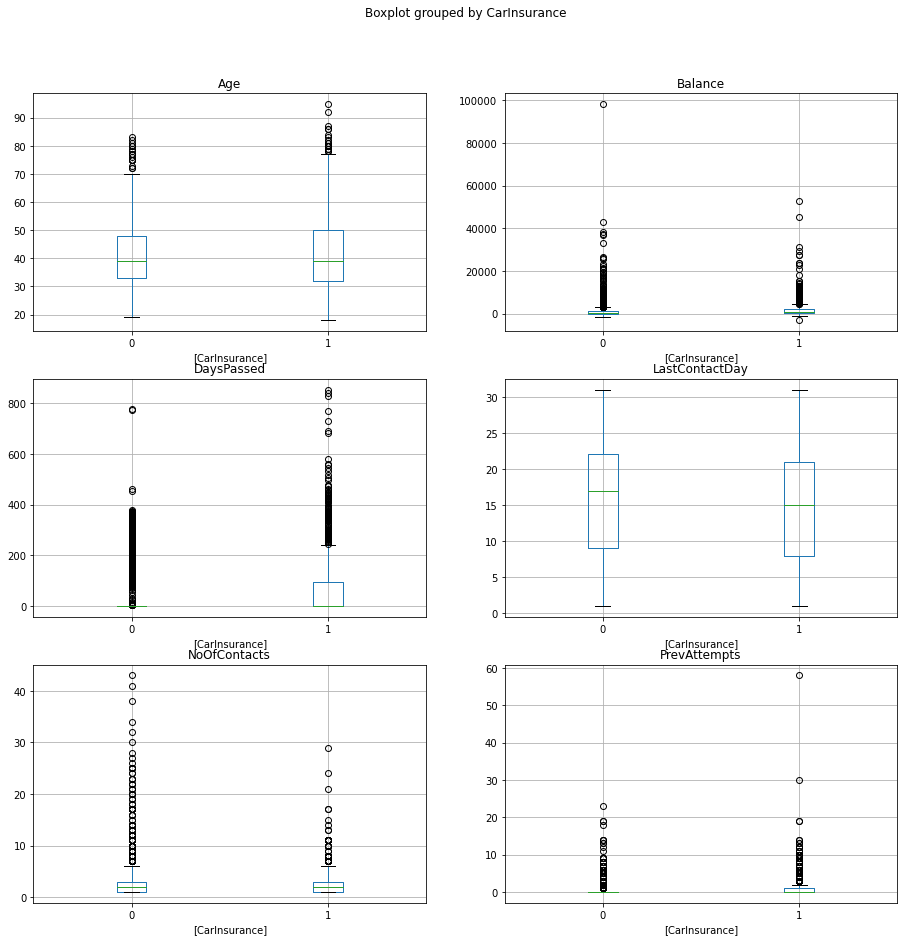

In [14]:
# Lets drop CarLoan, HHInsurance, Default from the numeric columns as these are dummies
num_cols_viz = ['DaysPassed', 'Age', 'NoOfContacts', 'PrevAttempts', 'LastContactDay', 'Balance']

fig, axes = plt.subplots(3,2,sharex=False,sharey=False, figsize=(15,15))
Insurance_Data.loc[:,[Target]+num_cols_viz].boxplot(by=Target, ax=axes, return_type='axes')

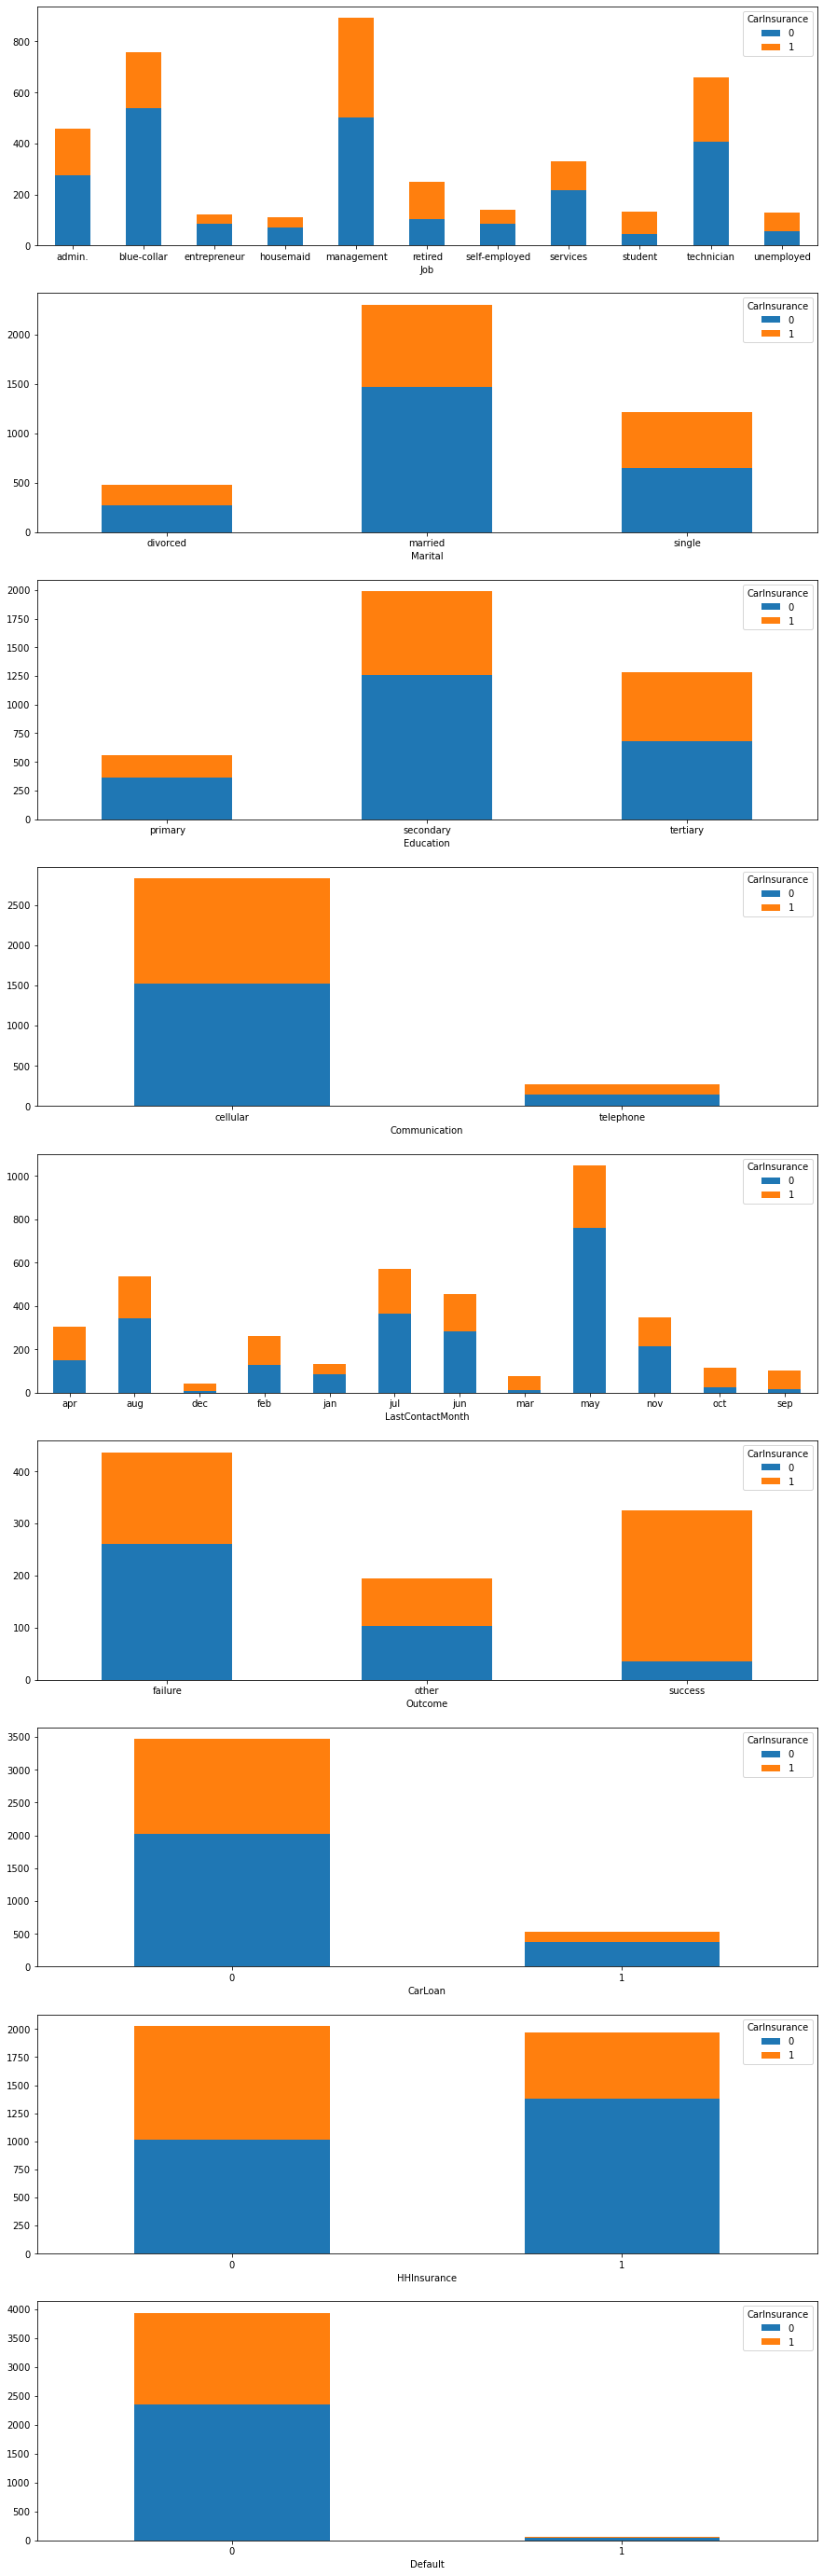

In [15]:
non_num_cols_viz = non_num_cols+['CarLoan', 'HHInsurance', 'Default']
fig, axes = plt.subplots(len(non_num_cols_viz),sharex=False,sharey=False, figsize=(15,50))
for i in range(len(non_num_cols_viz)):
    pd.crosstab(Insurance_Data[non_num_cols_viz[i]], Insurance_Data[Target]).plot(kind='bar', 
                                                                                  stacked=True, 
                                                                                  grid=False, 
                                                                                  ax=axes[i],
                                                                                  rot=0)

In [16]:
Insurance_Data.isnull().sum()

Id                     0
Age                    0
Job                   19
Marital                0
Education            169
Default                0
Balance                0
HHInsurance            0
CarLoan                0
Communication        902
LastContactDay         0
LastContactMonth       0
NoOfContacts           0
DaysPassed             0
PrevAttempts           0
Outcome             3042
CallStart              0
CallEnd                0
CarInsurance           0
dtype: int64

In [17]:
Insurance_Data_Org = Insurance_Data.copy()

In [18]:
Insurance_Data['Job'].value_counts(dropna=False)

management       893
blue-collar      759
technician       660
admin.           459
services         330
retired          249
self-employed    140
student          131
unemployed       130
entrepreneur     121
housemaid        109
NaN               19
Name: Job, dtype: int64

In [19]:
Insurance_Data['Job'] = Insurance_Data['Job'].fillna('None')
Insurance_Data['Job'].isnull().sum()

0

In [20]:
Insurance_Data['Job'].value_counts()

management       893
blue-collar      759
technician       660
admin.           459
services         330
retired          249
self-employed    140
student          131
unemployed       130
entrepreneur     121
housemaid        109
None              19
Name: Job, dtype: int64

In [21]:
# Fill missing education with the most common education level by job type

# Create job-education level mode mapping
edu_mode=[]

# What are different Job Types
job_types = Insurance_Data.Job.value_counts().index
job_types

Index(['management', 'blue-collar', 'technician', 'admin.', 'services',
       'retired', 'self-employed', 'student', 'unemployed', 'entrepreneur',
       'housemaid', 'None'],
      dtype='object')

In [22]:
# Now according to the job type we will crate a mapping where the job and mode of education is there.
# It means when there are many people in the managment job then most of them are in which education.
# We can find that in below mapping

for job in job_types:
    mode = Insurance_Data[Insurance_Data.Job==job]['Education'].value_counts().nlargest(1).index
    edu_mode = np.append(edu_mode,mode)
edu_map=pd.Series(edu_mode,index=Insurance_Data.Job.value_counts().index)

edu_map

management        tertiary
blue-collar      secondary
technician       secondary
admin.           secondary
services         secondary
retired          secondary
self-employed     tertiary
student          secondary
unemployed       secondary
entrepreneur      tertiary
housemaid          primary
None             secondary
dtype: object

In [23]:
# Apply the mapping to missing education obs. We will replace education now by jobs value
for j in job_types:
    Insurance_Data.loc[(Insurance_Data['Education'].isnull()) & (Insurance_Data['Job']==j),'Education'] = edu_map.loc[edu_map.index==j][0]

# For those who are not getting mapped we will create a new category as None
Insurance_Data['Education'].fillna('None',inplace=True)

In [24]:
Insurance_Data.isnull().sum()

Id                     0
Age                    0
Job                    0
Marital                0
Education              0
Default                0
Balance                0
HHInsurance            0
CarLoan                0
Communication        902
LastContactDay         0
LastContactMonth       0
NoOfContacts           0
DaysPassed             0
PrevAttempts           0
Outcome             3042
CallStart              0
CallEnd                0
CarInsurance           0
dtype: int64

In [25]:
# Fill missing communication with none 
Insurance_Data['Communication'].value_counts(dropna=False)

cellular     2831
NaN           902
telephone     267
Name: Communication, dtype: int64

In [26]:
Insurance_Data['Communication'] = Insurance_Data['Communication'].fillna('None')

In [27]:
# Check for missing value in Outcome
Insurance_Data['Outcome'].value_counts(dropna=False)

NaN        3042
failure     437
success     326
other       195
Name: Outcome, dtype: int64

In [28]:
# Fill missing outcome as not in previous campaign, we are adding one category to Outcome
# We will add category if the value of DaysPassed is -1

Insurance_Data.loc[Insurance_Data['DaysPassed']==-1,'Outcome']= 'NoPrev'
Insurance_Data['Outcome'].value_counts(dropna=False)

NoPrev     3042
failure     437
success     326
other       195
Name: Outcome, dtype: int64

In [29]:
# Check if we have any missing values left
Insurance_Data.isnull().sum()

Id                  0
Age                 0
Job                 0
Marital             0
Education           0
Default             0
Balance             0
HHInsurance         0
CarLoan             0
Communication       0
LastContactDay      0
LastContactMonth    0
NoOfContacts        0
DaysPassed          0
PrevAttempts        0
Outcome             0
CallStart           0
CallEnd             0
CarInsurance        0
dtype: int64

In [30]:
Insurance_Data_num = Insurance_Data[num_cols+['Id', 'CarInsurance']]

In [31]:
# Categorical columns data
Insurance_Data_cat = Insurance_Data[non_num_cols]
non_num_cols

['Job', 'Marital', 'Education', 'Communication', 'LastContactMonth', 'Outcome']

In [32]:
# Create dummies
Insurance_Data_cat_dummies = pd.get_dummies(Insurance_Data_cat)  #One-Hot Embedding
print(Insurance_Data_cat_dummies.shape)
Insurance_Data_cat_dummies.head()

(4000, 37)


,Job_None,Job_admin.,Job_blue-collar,Job_entrepreneur,Job_housemaid,Job_management,Job_retired,Job_self-employed,Job_services,Job_student,Job_technician,Job_unemployed,Marital_divorced,Marital_married,Marital_single,Education_primary,Education_secondary,Education_tertiary,Communication_None,Communication_cellular,Communication_telephone,LastContactMonth_apr,LastContactMonth_aug,LastContactMonth_dec,LastContactMonth_feb,LastContactMonth_jan,LastContactMonth_jul,LastContactMonth_jun,LastContactMonth_mar,LastContactMonth_may,LastContactMonth_nov,LastContactMonth_oct,LastContactMonth_sep,Outcome_NoPrev,Outcome_failure,Outcome_other,Outcome_success
0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
4,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0


In [33]:
Insurance_Data_final = pd.concat([Insurance_Data_num, Insurance_Data_cat_dummies], axis=1)
print(Insurance_Data_final.shape)
Insurance_Data_final.head()

(4000, 48)


,Age,Default,Balance,HHInsurance,CarLoan,LastContactDay,NoOfContacts,DaysPassed,PrevAttempts,Id,CarInsurance,Job_None,Job_admin.,Job_blue-collar,Job_entrepreneur,Job_housemaid,Job_management,Job_retired,Job_self-employed,Job_services,Job_student,Job_technician,Job_unemployed,Marital_divorced,Marital_married,Marital_single,Education_primary,Education_secondary,Education_tertiary,Communication_None,Communication_cellular,Communication_telephone,LastContactMonth_apr,LastContactMonth_aug,LastContactMonth_dec,LastContactMonth_feb,LastContactMonth_jan,LastContactMonth_jul,LastContactMonth_jun,LastContactMonth_mar,LastContactMonth_may,LastContactMonth_nov,LastContactMonth_oct,LastContactMonth_sep,Outcome_NoPrev,Outcome_failure,Outcome_other,Outcome_success
0,32,0,1218,1,0,28,2,-1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
1,32,0,1156,1,0,26,5,-1,0,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
2,29,0,637,1,0,3,1,119,1,3,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
3,25,0,373,1,0,11,2,-1,0,4,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
4,30,0,2694,0,0,3,1,-1,0,5,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0


In [34]:
# Checking if there are missing values before we run model
Insurance_Data_final.isnull().sum(axis = 0)

Age                        0
Default                    0
Balance                    0
HHInsurance                0
CarLoan                    0
LastContactDay             0
NoOfContacts               0
DaysPassed                 0
PrevAttempts               0
Id                         0
CarInsurance               0
Job_None                   0
Job_admin.                 0
Job_blue-collar            0
Job_entrepreneur           0
Job_housemaid              0
Job_management             0
Job_retired                0
Job_self-employed          0
Job_services               0
Job_student                0
Job_technician             0
Job_unemployed             0
Marital_divorced           0
Marital_married            0
Marital_single             0
Education_primary          0
Education_secondary        0
Education_tertiary         0
Communication_None         0
Communication_cellular     0
Communication_telephone    0
LastContactMonth_apr       0
LastContactMonth_aug       0
LastContactMon

In [35]:
train_df = Insurance_Data_final.drop(['Id', 'CarInsurance'], axis=1) #X
train_label = Insurance_Data_final['CarInsurance'] #y

In [36]:
#random_state is the seed used by the random number generator. It can be any integer.
# Train test split
X_train, X_test, y_train, y_test = train_test_split(train_df, train_label, train_size=0.7 , stratify=train_label, random_state=100)

In [ ]:
# Stratify option will make sure that train has both the classes, and also test has both the classes in 70-30
# Guarantee that:
# train 7 rows(5 rows class 0, 2 rows class 1)
# test 3 rows (2 rows class 0, 1 row of class1)

In [37]:
print(y_train.shape[0]) # 2800, 1123 are 1s and the rest (2800-1123=1677) 0s
print(np.sum(y_train))
print(y_test.shape[0]) # 1200, 481 are 1s and the rest (1200-481=719) 0s
print(np.sum(y_test))

2800
1123
1200
481


In [38]:
print('Train shape - ', X_train.shape)
print('Test shape  - ', X_test.shape)

Train shape -  (2800, 46)
Test shape  -  (1200, 46)


In [39]:
# Define Model parameters to tune
model_parameters = {
        'kernel':['rbf'], #['rbf', 'poly', 'linear', 'sigmoid']
        'C': [1], # [0, 1, 10, 100, 1000, 1e15] C is reciprocal of Lambda, strength of Lambda; 
# Lambda = 0(Plain Logistic Regression , No Regularization), C = 1/0, feed very very big number to C (1e15)
# Lambda = Very big number(Heavy Regularization, weights will almost die,0), C = 1/inf, C = 0
        'class_weight': ['balanced'], #['balanced', None]
        'gamma': [0.0001] #[0.0001, 'scale', 'auto']
    }

In [40]:
# Gridsearch the parameters to find the best parameters.
model = SVC(probability=True, random_state=34)  # Support vector classifier

gscv = GridSearchCV(estimator=model, 
                    param_grid=model_parameters, 
                    cv=3,  # 3-Fold Cross Validation
#                     
                    verbose=3, #To print what it is doing
                    n_jobs=-1, #fastest possible depending in the laptop
                    scoring='roc_auc')
# scoring='roc_auc' (Almost always try that.)

gscv.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    8.7s finished


GridSearchCV(cv=3, estimator=SVC(probability=True, random_state=34), n_jobs=-1,
             param_grid={'C': [1], 'class_weight': ['balanced'],
                         'gamma': [0.0001], 'kernel': ['rbf']},
             scoring='roc_auc', verbose=3)

In [41]:
print('The best parameter are -', gscv.best_params_)

The best parameter are - {'C': 1, 'class_weight': 'balanced', 'gamma': 0.0001, 'kernel': 'rbf'}


In [42]:
print(gscv.best_score_)
print(gscv.best_estimator_)
print(gscv.scorer_)

0.6114906488859978
SVC(C=1, class_weight='balanced', gamma=0.0001, probability=True,
    random_state=34)
make_scorer(roc_auc_score, needs_threshold=True)


In [43]:
print('AUC on test by gscv =', roc_auc_score(y_true=y_test,
                                                        y_score=gscv.predict_proba(X_test)[:, 1]))

AUC on test by gscv = 0.5876896474949326


Train AUC =  0.7294924628478855
Test AUC =  0.5876896474949326


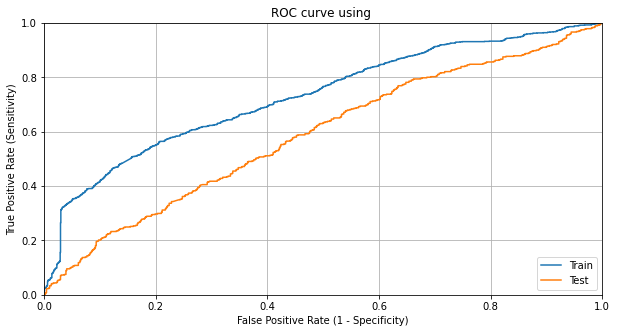

In [44]:
# Generate ROC
plt.subplots(figsize=(10, 5))
train_prob = gscv.predict_proba(X_train)[:, 1]
test_prob = gscv.predict_proba(X_test)[:, 1]

plot_roc_curve(y_train, train_prob,
               y_test, test_prob)